# Support Vector Machines' SMO Algorithm:
## An Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, rand, seed
from itertools import combinations

### Coordinate ascent

Iterate until convergence:  
For $i=1,\ldots,m\{$  
$
\quad\quad \alpha_i := \arg\max_{\hat\alpha_i} W(\alpha_1, \ldots, \alpha_{i-1}, \hat\alpha_i, \alpha_{i+1}, \ldots, \alpha_m)
$  
$\}$

---
**An Example** $f(x, y) = -(x^2 + y^2) + xy$

* $g(y) = \arg\max_x f(x, y) = y/2$
* $g(x)  = \arg\max_y f(x, y) = x/2$

In [2]:
coords = [2, -2]
steps = [coords[:]]
x, y = coords
for i in range(10):
    for i, coord in enumerate(coords):
        coords[i] = coords[abs(1 - i)]/2
        steps.append(coords[:])
steps[:5]

[[2, -2], [-1.0, -2], [-1.0, -0.5], [-0.25, -0.5], [-0.25, -0.125]]

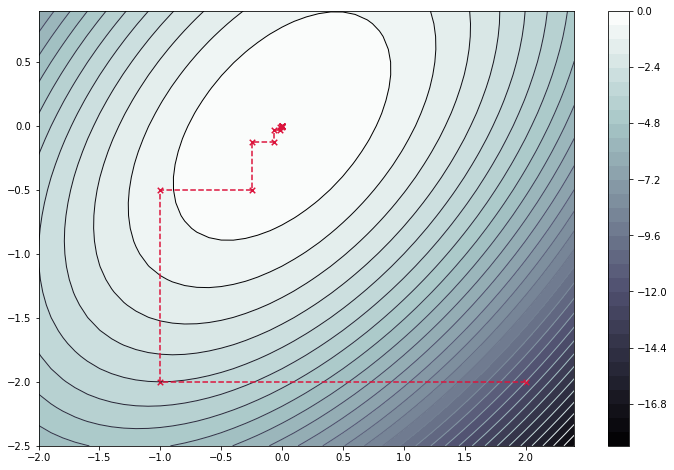

In [3]:
plt.figure(figsize=(12, 8))
def f(x, y): return -(x**2 + y**2) + x * y
xx, yy = np.mgrid[-2:2.5:0.1, -2.5:1:0.1]
plt.contour(xx, yy, f(xx, yy), 30, cmap=plt.cm.bone_r, linewidths=1)
plt.contourf(xx, yy, f(xx, yy), 30, cmap=plt.cm.bone)
plt.colorbar()
plt.scatter(*np.r_[steps].T, color="crimson", s=30, marker="x")
plt.plot(*np.r_[steps].T, color="crimson", linestyle="--");

<h2 style="color:teal">SMO</h2>

The dual problem of a suport vector machine is given by 
$$
    \max_\alpha W(\alpha) = \sum_{i=1}^n\alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n \alpha_i\alpha_j y_i y_j (x^{(i)})^T x^{(j)}\\
    \mbox{s.t. } 0 \leq \alpha_i \leq C \ \forall i \in \{1, \ldots, n\}\\
    \sum_{i=1}^n\alpha_iy_i = 0
$$

In order to solve $\arg\max_{\alpha}W(\alpha)$ we make use of the *coordinate ascent* algorithm. To do so, we first note that the second restriction of the dual is 
$$
  \sum_{i=1}^n\alpha_iy_i = 0
$$
This implies 
$$
\alpha_i = - yi\sum_{\{j \ | \ j\neq i\}}\alpha_jy_j \ \forall \ i.
$$
That is, every $\alpha_i$ term is completely determined by all other $\{\alpha_j\}_{j \neq i}$. To solve this problem, the SMO algorithm updates two $\alpha$ terms at a time.

Suppose we have $\alpha \in \mathbb{R}^n$ that satisfy the constraits contraints. We consider $\alpha_i, \alpha_j \in \alpha$ so that
$$
    \alpha_iy_i + \alpha_jy_j = -\sum_{\{k \ | \ k \neq i, j\}} \alpha_ky_k
$$

For fixed $\{\alpha_k\}_{\{k \ | \ k \neq i, j\}}$, $-\sum_{\{k \ | \ k \neq i, j\}} \alpha_ky_k$ is a constant, which we will denote with $\zeta$. We now have:
$$
    \alpha_iy_i + \alpha_jy_j = \zeta
$$

Since $0\leq \alpha_i, \alpha_j\leq C$ (first constraint), we can picture the values $\alpha_i, \alpha_j$ as being surrounded by a box.
<img src="alpha_box.png" width=600px>
From the picture above we note that $\alpha_j$ is also bounded by $H$ and $L$, since $\alpha_j > H$ or $\alpha_j < L$ would imply to be outside the $[0, C]\times[0, C]$ box.

Where
$$
    L = \max\{0, \alpha_j - \alpha_i\};\ H = \min\{C, C + \alpha_j - \alpha_i\}
$$
For $sign(y_j) \neq sign(y_i)$

And,
$$
    L = \max\{0, \alpha_j + \alpha_i - C\};\ H = \min\{C, \alpha_j + \alpha_i\}
$$
For $sign(y_j) = sign(y_i)$

From
$$
    \alpha_iy_i + \alpha_jy_j = \zeta \Longrightarrow \alpha_i = y_i(\zeta - \alpha_j y_j)
$$

We now express the objective function $W(\alpha)$
$$
    W(\alpha_1, \ldots, \alpha_i, \ldots, \alpha_j, \alpha_n) = W(\alpha_1, \ldots, y_i(\zeta - \alpha_j y_j), \ldots, \alpha_j, \alpha_n)
$$

Which so happens to be a quadratic function over $\alpha_j$, i.e, we can express $W(\alpha)$, with $\alpha_i = y_i(\zeta - \alpha_j y_j)$ as

$$
    W(\alpha) = -\frac{1}{2}\left(\alpha_j^2A_1 + \alpha_jA_2 + A_3\right)
$$

To find the factors $A_1, A_2, A_3$ we use *sympy*:

In [37]:
from sympy import symbols, init_printing, factor, simplify, expand
import sympy
init_printing()
a1, a2, a3, a4, a5 = symbols("alpha1 alpha2 alpha3 alpha4 alpha5")
y1, y2, y3, y4, y5 = symbols("y_1 y_2 y_3 y_4 y_5")
x1, x2, x3, x4, x5 = symbols("x_1 x_2 x_3 x_4 x_5")
zeta, C = symbols("zeta C")

# In orde to solve the dual, we must solve two terms
# at a time
a1 = (zeta - a2 * y2) * y1

In [38]:
alpha = [a1, a2, a3, a4, a5]
y = [y1, y2, y3, y4, a5]
x = [x1, x2, x3, x4, a5]

def compute_dual(alpha, x, y):
    """
    Given a sympy list of alpha, x, and y terms,
    compute dual cost function of a support vector
    machine.
    """
    dual = sum(alpha)
    from itertools import product
    for (ai, yi, xi), (aj, yj, xj) in product(zip(alpha, y, x), zip(alpha, y, x)):
        dual -= ai * aj * yi * yj * xi * xj / 2
    
    return dual

The cost function considering $\{\alpha_k\}_{k=1}^3$

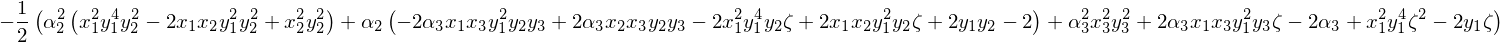

In [39]:
factor(compute_dual(alpha[:3], x, y), a2)

The cost function considering $\{\alpha_k\}_{k=1}^4$

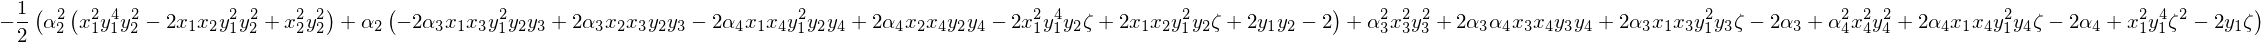

In [48]:
factor(compute_dual(alpha[:4], x, y), a2)

The cost function considering $\{\alpha_k\}_{k=1}^5$

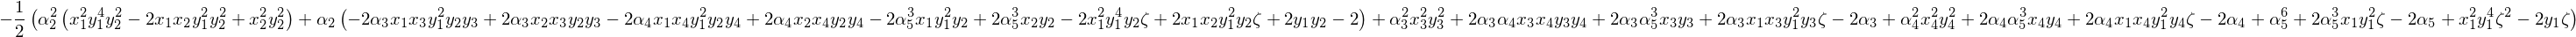

In [6]:
factor(compute_dual(alpha, x, y), a2)

Some helpful identities

In [7]:
expand((a3 * x3 * y3 + a4 * x4 * y4 + a5 * x5 * y5) ** 2 )

----
From the analysis above, we note that the terms $A_1, A_2, A_3$ for $-\frac{1}{2}\left(\alpha_j^2A_1 + \alpha_jA_2 + A_3\right)$ are

$$
    A_1 = \left(x^{(i)} - x^{(j)}\right)^T\left(x^{(i)} - x^{(j)}\right)
$$

$$
    A_2 = 2\left(-\sum_{\{k \ | \ k \neq i, j\}}\alpha_k(x^{(i)})^Tx^{(k)}y_jy_k + \sum_{\{k \ | \ k \neq i, j\}}\alpha_k(x^{(j)})^Tx^{(k)}y_jy_k - \zeta(x^{(i)})^Tx^{(i)} + \zeta(x^{(i)})^Tx^{(j)}y_j+ y_iy_j - 1\right)
$$

$$
    A_3 = \left(\sum_{\{k \ | \ k \neq i, j\}}\alpha_kx_ky_k\right)^T \left(\sum_{\{k \ | \ k \neq i, j\}}\alpha_kx_ky_k\right) - 2\sum_{\{k \ | \ k \neq i, j\}}\alpha_k + 2\zeta\sum_{\{k \ | \ k \neq i, j\}}\alpha_k(x^{(i)})^Tx^{(k)}y_k + \zeta^2(x^{(i)})^Tx^{(i)} - 2\zeta y_i
$$

Ignoring the box constraint, i.e., $L \leq \alpha_j \leq H$, we can take a step of coordinate ascent considering $W(\alpha) = -\frac{1}{2}\left(\alpha_j^2A_1 + \alpha_jA_2 + A_3\right)$ (a concave function) by maximizing $W(\alpha)$ w.r.t. $\alpha_j$:

$$
\begin{align}
    \frac{\partial}{\partial \alpha_j}W(\alpha) &= \frac{\partial}{\partial \alpha_j}\left(-\frac{1}{2}\left(\alpha_j^2A_1 + \alpha_jA_2 + A_3\right)\right) \\
    &= -\frac{1}{2}\left(2\alpha_jA_1  + A_2 \right)
\end{align}
$$

Setting the derivative to 0 and solving we note that  
$$
\begin{align}
    \alpha_j^{unclipped} = -\frac{A_2}{2A_1}
\end{align}
$$
To comply with the box constraint, we must *clip* $\alpha_j^{unclipped}$ to guarantee that is indeed bounded bounded by the $[0, C]\times [0, C]$ box as follows:
$$
    \alpha_j^{clipped} = \begin{cases}
        H & \alpha_j^{unclipped} > H \\
        \alpha_j^{unclipped} & L \leq \alpha_j^{unclipped} \leq H\\
        L & \alpha_j^{unclipped} < L
   \end{cases}
$$

Having found $\alpha_j^{clipped}$, it is possible to know $\alpha_i$ considering $\alpha_i = y_i(\zeta - \alpha_j y_j)$

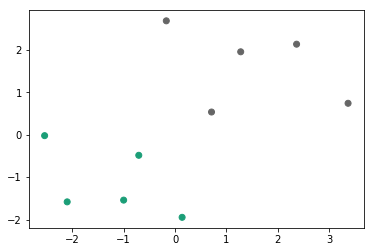

In [4]:
seed(31415)
X = np.r_[randn(5, 2) + 1, randn(5, 2) - 1].T
y = np.r_[np.ones((5, 1)), - np.ones((5, 1))]

plt.scatter(*X, c=y.ravel(), cmap=plt.cm.Dark2)

seed(31415)
_, ntrain = X.shape
# Initalize alphas
alpha = np.zeros((ntrain, 1))

In [9]:
seed(1643)
# Choosing two random variables
i, j = np.random.choice(range(ntrain), size=2, replace=False)
xi = X[:, [i]]
xj = X[:, [j]]
yi = y[i][0]
yj = y[j][0]

# every X, y element but indices i, j
xrem = np.delete(X, [i, j], axis=1)
yrem = np.delete(y, [i, j])
alpharem = np.delete(alpha, [i, j])
zeta = - (alpharem * yrem).sum()

aj = alpha[j,0]
ai = yi * (zeta - aj * yj)

C = 1

A1 = ((xi - xj).T @ (xi - xj)).ravel()[0]

A2 = 2 * (-(alpharem * (xi.T @ xrem).ravel() * yi * yrem).sum() + \
     (alpharem * (xj.T @ xrem).ravel() * yj * yrem).sum() + \
     - zeta * xi.T @ xj * yj + yi * yj - 1); A2 = np.asscalar(A2)
        
A3 = (alpharem * xrem * yrem).sum(axis=0) @ (alpharem * xrem * yrem).sum(axis=0) - \
     2 * alpharem.sum() + 2 * zeta * (alpharem * (xi.T @ xrem) * yrem).sum() + \
     zeta ** 2 * xi.T @ xi - 2 * zeta * yi; A3 = np.asscalar(A3)
        
if yi != yj:
    L = np.maximum(0, aj - ai)
    H = np.minimum(C, C + aj - ai)
else:
    L = np.maximum(0, aj + ai - C)
    H = np.minimum(C, aj + ai)
    
    
aj_unclipped = - A2 / (2 * A1)
aj = np.clip(aj_unclipped, L, H)
ai = (zeta - aj * yj) * yi

### How to choose which $\alpha_i, \alpha_j$ to update?
Consider chosing $\alpha_i$, $\alpha_j$ as two random indices

array([[ 0.17553826],
       [ 0.        ],
       [ 0.1268947 ],
       [ 0.10985287],
       [ 0.46363535],
       [ 0.17553826],
       [ 0.14538651],
       [ 0.        ],
       [ 0.16890519],
       [ 0.38609122]])

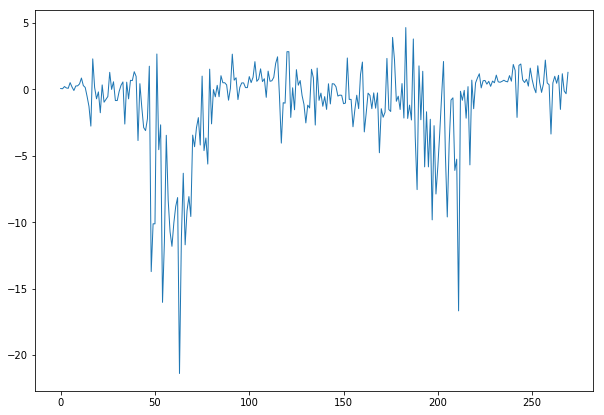

In [20]:
from svm import SupportVectorMachine

seed(31415)
svc = SupportVectorMachine(1, X, y)

cost = []
for epoch in range(270):
    i, j = np.random.choice(range(ntrain), size=2, replace=False)
    svc._select_target_alpha(i, j)
    svc._update_aij()
    cost.append(svc._compute_cost())
    
plt.figure(figsize=(10,7))
plt.plot(cost, linewidth=1)
svc.alpha

### How to choose which $\alpha_i, \alpha_j$ to update?
Consider chosing $\alpha_i$, $\alpha_j$ as an ordered combination pair 

array([[ 1.        ],
       [ 0.34967748],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [ 0.21925006],
       [-0.        ],
       [ 0.81430668],
       [ 0.31612074]])

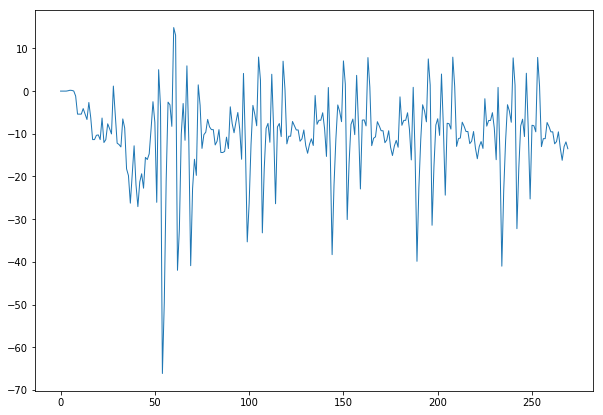

In [5]:
from importlib import reload
from itertools import combinations
import svm
reload(svm)
from svm import SupportVectorMachine

seed(31415)
svc = SupportVectorMachine(1, X, y)

cost = []
for epoch in range(6):
    for i, j in combinations(range(ntrain), 2):
        svc._select_target_alpha(i, j)
        svc._update_aij()
        cost.append(svc._compute_cost())
    
plt.figure(figsize=(10,7))
plt.plot(cost, linewidth=1)
svc.alpha

### How to choose which $\alpha_i, \alpha_j$ to update?
SMO's heuristics $\alpha_i$, $\alpha_j$

Consider
$$
    w^T x + b = \sum_{i=1}^b \alpha_i y_i (x^{(i)})^T x + b
$$

In the SMO algorithm, $b$ is re-computed after each step, that the KKT conditions are fulfilled for both optimized examples.

